In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# for loading MNIST data
from torchvision import transforms, datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [3]:
# if cuda device is available then run model on gpu
if torch.cuda.is_available():
    cuda_flag=True
else:
    cuda_flag=False

### Setting up data loader

In [4]:
batch_size=64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./dataset/', train=True, download=True,transform=transform),
                batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./dataset/', train=False, download=True, transform=transform),
                 batch_size=batch_size)

### Class Definitions for Models
For a Generative Adversarial Network we have a Discriminator and a Generator model. The Generator tries to generate an example which mimics the real data, whereas Discriminator tries to discriminate between real data and the examples gnerated by Generator. Both the models try to fool each other and in this process keep improving over each iteration.

In [5]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

### Training the models

In [6]:
# generate random input vector for generator
def noise(batch_size):
    n = (torch.randn(batch_size, 100))
    return n

In [7]:
# initialize the networks
torch.manual_seed(42)
D = Discriminator(784)
G = Generator(100, 784)

if (cuda_flag):
    D = D.cuda()
    G = G.cuda()

For each network we define a separate optimizer as we would be training our networks one at a time.
We would be using Binary Cross Entropy loss function since the discriminator needs to make a binary choice while differentating between real and fake images

In [8]:
# define optimizers for each network
d_optimizer = optim.Adam(D.parameters(), lr=2e-4, weight_decay=1e-4)
g_optimizer = optim.Adam(G.parameters(), lr=2e-4, weight_decay=1e-4)

crit = nn.BCELoss(reduction='mean')

In [9]:
# training function for generator
def g_train():
    gen_train_loss=0
    g_optimizer.zero_grad()    
    x = noise(batch_size)
    if cuda_flag:
        x = x.cuda()

    fake_data = G(x)
    y_pred = D(fake_data)
    loss = crit(y_pred, real_labels)
    gen_train_loss+=loss.item()

    loss.backward()
    g_optimizer.step()
    return gen_train_loss

In [10]:
# training function for discriminator
def d_train(x):
    dis_train_loss = 0
    # training discriminator on real data
    d_optimizer.zero_grad()

    if cuda_flag:
        x = x.view(len(x),-1).cuda()

    y_pred = D(x)
    real_loss = crit(y_pred, torch.ones(len(x),1).cuda())
    dis_train_loss+= real_loss.item()

    # training discriminator on fake data
    x = noise(batch_size)
    if cuda_flag:
        x = x.cuda()

    fake_data = G(x).detach()
    y_pred = D(fake_data)
    fake_loss = crit(y_pred, torch.zeros(batch_size,1).cuda())
    dis_train_loss+= fake_loss.item()

    loss = real_loss+fake_loss
    loss.backward()
    d_optimizer.step()
    
    return dis_train_loss

In [11]:
epochs = 80
gen_loss = []
dis_loss = []
real_labels = torch.ones(batch_size,1).cuda()
fake_labels = torch.zeros(batch_size,1).cuda()

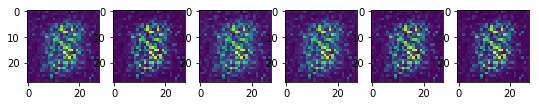

Epoch:0    Discriminator Loss:1.130095   Generator Loss:1.965640


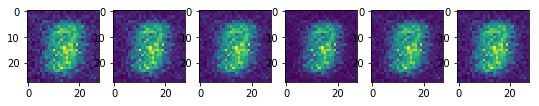

Epoch:1    Discriminator Loss:1.168013   Generator Loss:1.372630


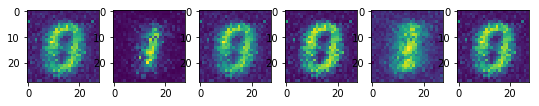

Epoch:2    Discriminator Loss:0.644002   Generator Loss:2.366564


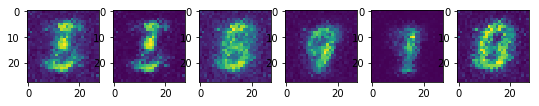

Epoch:3    Discriminator Loss:0.571783   Generator Loss:2.464344


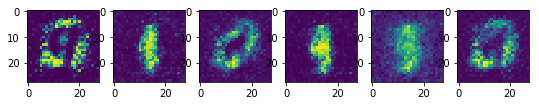

Epoch:4    Discriminator Loss:0.654150   Generator Loss:2.319977


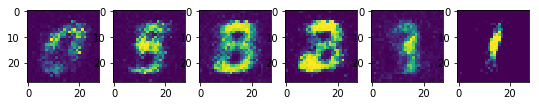

Epoch:5    Discriminator Loss:0.677258   Generator Loss:2.252015


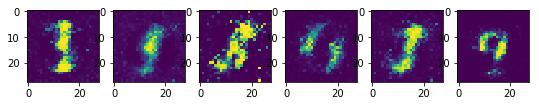

Epoch:6    Discriminator Loss:0.705975   Generator Loss:2.060169


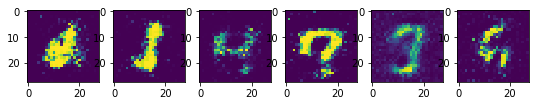

Epoch:7    Discriminator Loss:0.771239   Generator Loss:1.933946


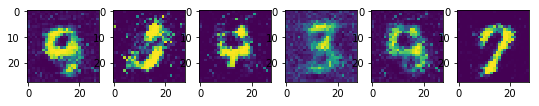

Epoch:8    Discriminator Loss:0.791762   Generator Loss:1.846859


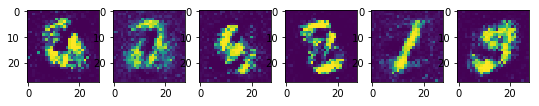

Epoch:9    Discriminator Loss:0.801045   Generator Loss:1.875376


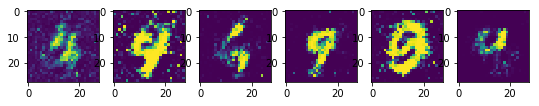

Epoch:10    Discriminator Loss:0.865456   Generator Loss:1.696805


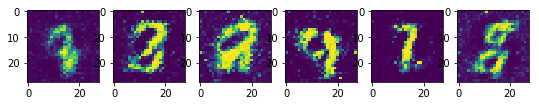

Epoch:11    Discriminator Loss:0.881914   Generator Loss:1.670781


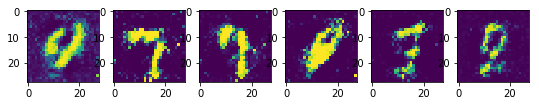

Epoch:12    Discriminator Loss:0.894872   Generator Loss:1.599604


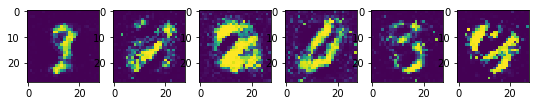

Epoch:13    Discriminator Loss:0.901210   Generator Loss:1.572039


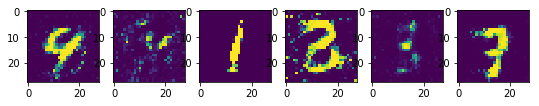

Epoch:14    Discriminator Loss:0.958817   Generator Loss:1.462247


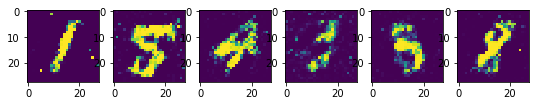

Epoch:15    Discriminator Loss:0.966819   Generator Loss:1.446684


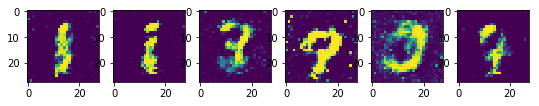

Epoch:16    Discriminator Loss:0.965804   Generator Loss:1.462482


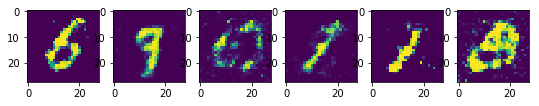

Epoch:17    Discriminator Loss:0.961970   Generator Loss:1.457655


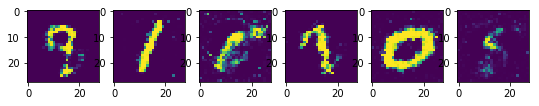

Epoch:18    Discriminator Loss:0.984699   Generator Loss:1.411646


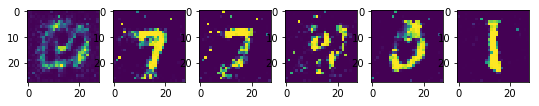

Epoch:19    Discriminator Loss:1.035334   Generator Loss:1.310574


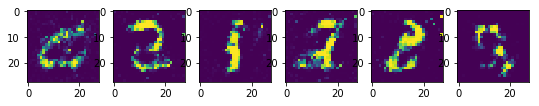

Epoch:20    Discriminator Loss:1.043279   Generator Loss:1.295532


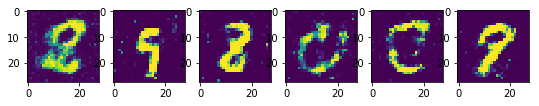

Epoch:21    Discriminator Loss:1.043232   Generator Loss:1.299987


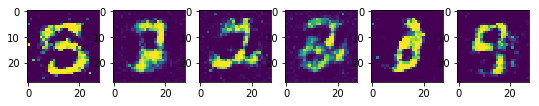

Epoch:22    Discriminator Loss:1.081058   Generator Loss:1.226352


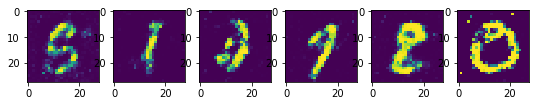

Epoch:23    Discriminator Loss:1.095062   Generator Loss:1.198928


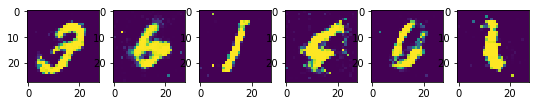

Epoch:24    Discriminator Loss:1.105973   Generator Loss:1.175669


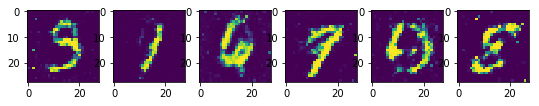

Epoch:25    Discriminator Loss:1.103272   Generator Loss:1.188042


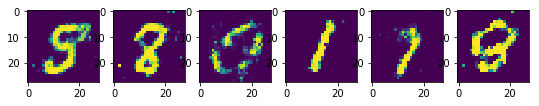

Epoch:26    Discriminator Loss:1.093531   Generator Loss:1.201336


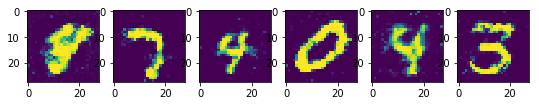

Epoch:27    Discriminator Loss:1.121024   Generator Loss:1.153903


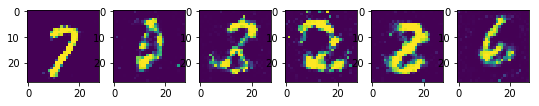

Epoch:28    Discriminator Loss:1.137622   Generator Loss:1.124288


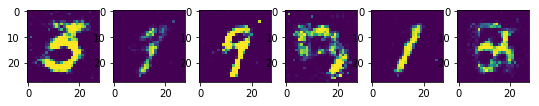

Epoch:29    Discriminator Loss:1.148235   Generator Loss:1.096808


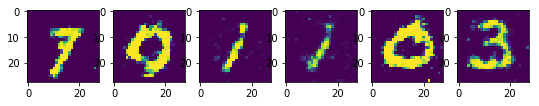

Epoch:30    Discriminator Loss:1.151008   Generator Loss:1.094523


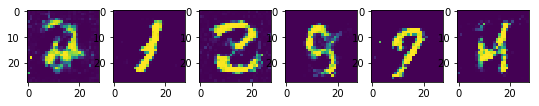

Epoch:31    Discriminator Loss:1.153124   Generator Loss:1.093539


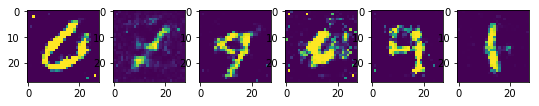

Epoch:32    Discriminator Loss:1.174397   Generator Loss:1.046442


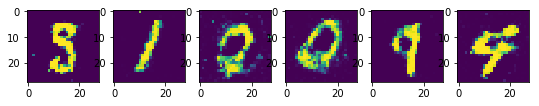

Epoch:33    Discriminator Loss:1.175904   Generator Loss:1.051007


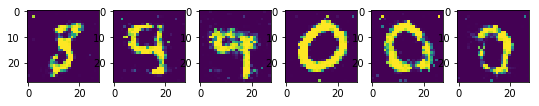

Epoch:34    Discriminator Loss:1.181489   Generator Loss:1.039468


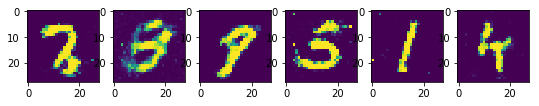

Epoch:35    Discriminator Loss:1.189674   Generator Loss:1.020624


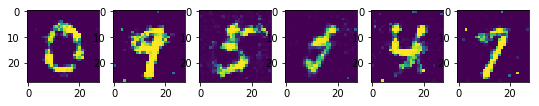

Epoch:36    Discriminator Loss:1.189605   Generator Loss:1.024482


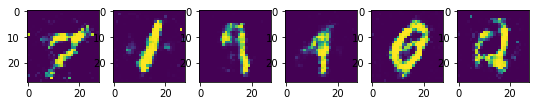

Epoch:37    Discriminator Loss:1.191560   Generator Loss:1.025862


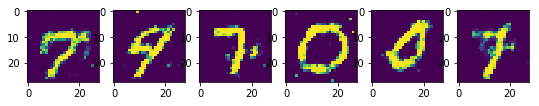

Epoch:38    Discriminator Loss:1.190072   Generator Loss:1.017621


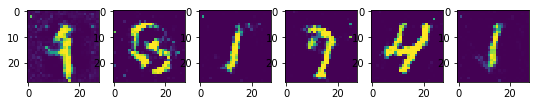

Epoch:39    Discriminator Loss:1.192197   Generator Loss:1.009901


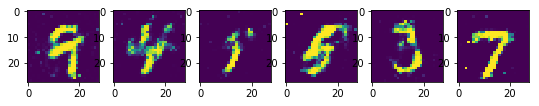

Epoch:40    Discriminator Loss:1.199764   Generator Loss:1.007938


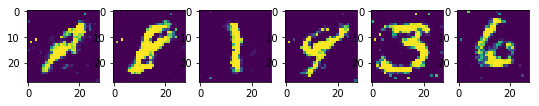

Epoch:41    Discriminator Loss:1.188585   Generator Loss:1.022205


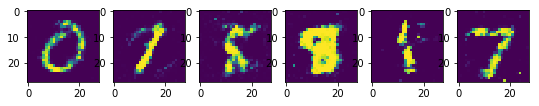

Epoch:42    Discriminator Loss:1.193480   Generator Loss:1.018467


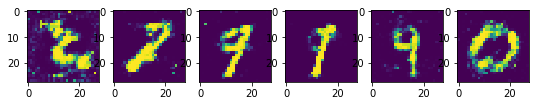

Epoch:43    Discriminator Loss:1.200082   Generator Loss:0.998940


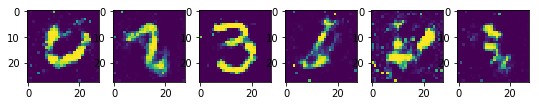

Epoch:44    Discriminator Loss:1.204057   Generator Loss:0.993120


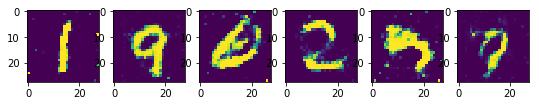

Epoch:45    Discriminator Loss:1.196131   Generator Loss:1.005138


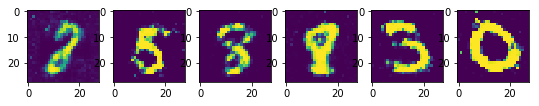

Epoch:46    Discriminator Loss:1.203941   Generator Loss:0.999603


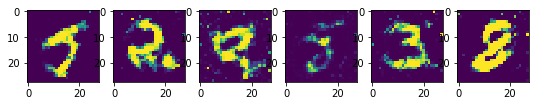

Epoch:47    Discriminator Loss:1.206743   Generator Loss:0.986029


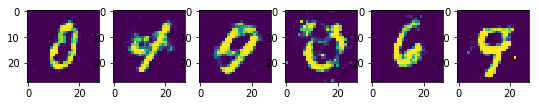

Epoch:48    Discriminator Loss:1.218751   Generator Loss:0.968015


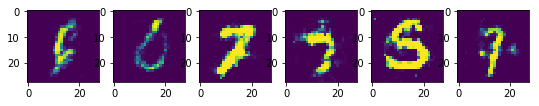

Epoch:49    Discriminator Loss:1.226094   Generator Loss:0.960568


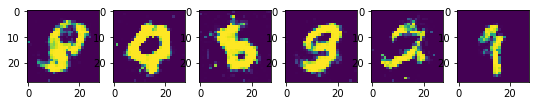

Epoch:50    Discriminator Loss:1.217147   Generator Loss:0.970160


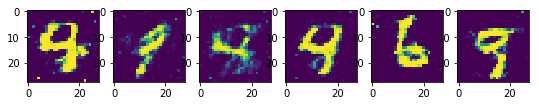

Epoch:51    Discriminator Loss:1.213358   Generator Loss:0.978570


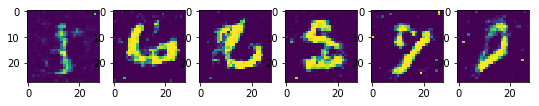

Epoch:52    Discriminator Loss:1.216254   Generator Loss:0.968001


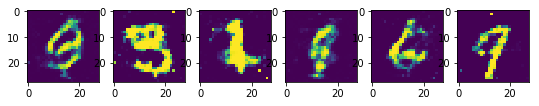

Epoch:53    Discriminator Loss:1.216321   Generator Loss:0.965764


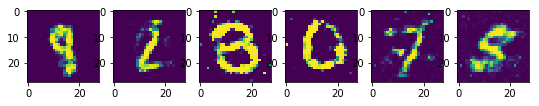

Epoch:54    Discriminator Loss:1.214955   Generator Loss:0.975153


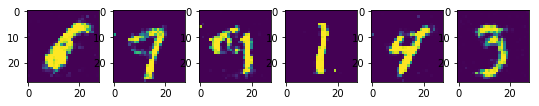

Epoch:55    Discriminator Loss:1.227526   Generator Loss:0.956447


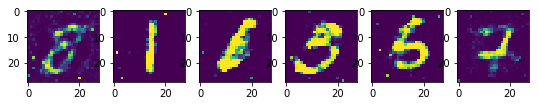

Epoch:56    Discriminator Loss:1.221713   Generator Loss:0.963027


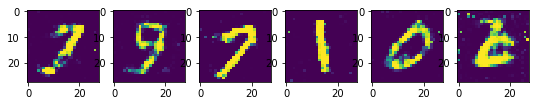

Epoch:57    Discriminator Loss:1.227275   Generator Loss:0.956476


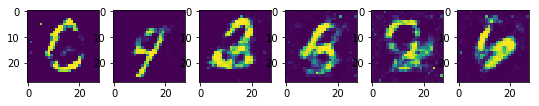

Epoch:58    Discriminator Loss:1.227684   Generator Loss:0.947625


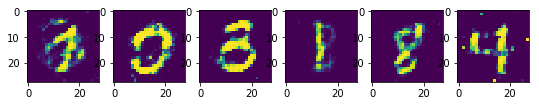

Epoch:59    Discriminator Loss:1.237146   Generator Loss:0.938301


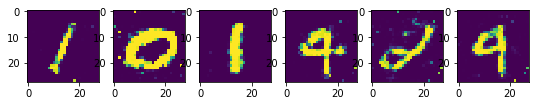

Epoch:60    Discriminator Loss:1.236555   Generator Loss:0.941019


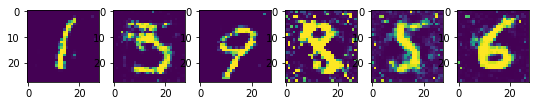

Epoch:61    Discriminator Loss:1.233931   Generator Loss:0.942403


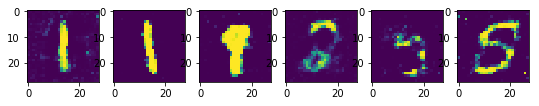

Epoch:62    Discriminator Loss:1.234151   Generator Loss:0.940940


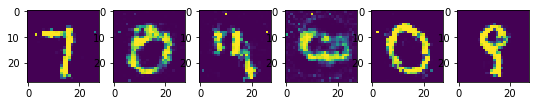

Epoch:63    Discriminator Loss:1.231716   Generator Loss:0.943284


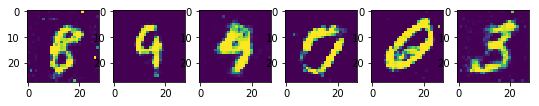

Epoch:64    Discriminator Loss:1.232110   Generator Loss:0.940283


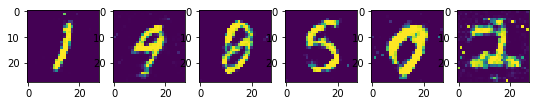

Epoch:65    Discriminator Loss:1.235697   Generator Loss:0.942054


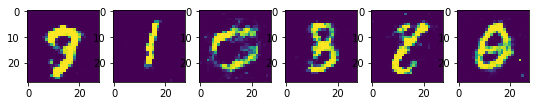

Epoch:66    Discriminator Loss:1.232602   Generator Loss:0.953980


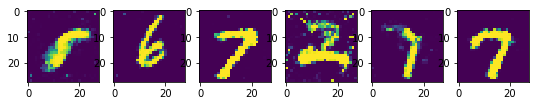

Epoch:67    Discriminator Loss:1.229916   Generator Loss:0.944265


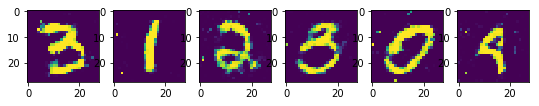

Epoch:68    Discriminator Loss:1.239452   Generator Loss:0.930380


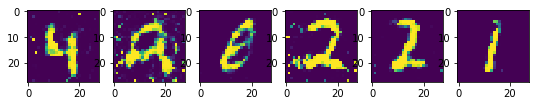

Epoch:69    Discriminator Loss:1.236833   Generator Loss:0.941003


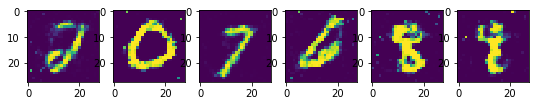

Epoch:70    Discriminator Loss:1.238603   Generator Loss:0.925982


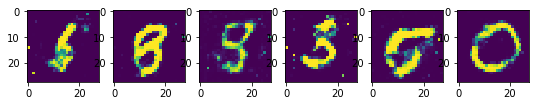

Epoch:71    Discriminator Loss:1.239684   Generator Loss:0.938726


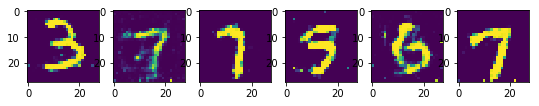

Epoch:72    Discriminator Loss:1.242717   Generator Loss:0.926251


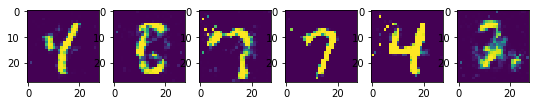

Epoch:73    Discriminator Loss:1.240296   Generator Loss:0.931486


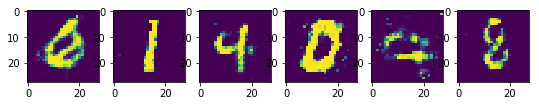

Epoch:74    Discriminator Loss:1.241871   Generator Loss:0.929674


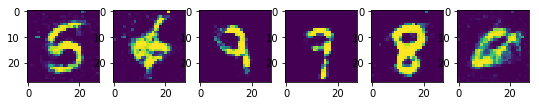

Epoch:75    Discriminator Loss:1.238352   Generator Loss:0.932179


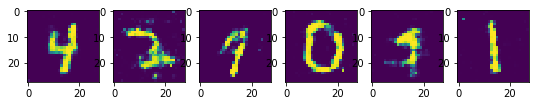

Epoch:76    Discriminator Loss:1.245884   Generator Loss:0.919638


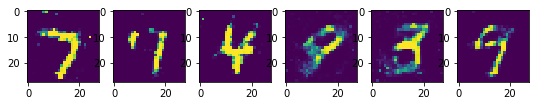

Epoch:77    Discriminator Loss:1.240595   Generator Loss:0.928656


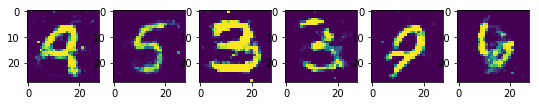

Epoch:78    Discriminator Loss:1.246610   Generator Loss:0.927003


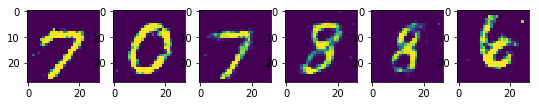

Epoch:79    Discriminator Loss:1.248958   Generator Loss:0.920474



In [12]:
steps=0
for epoch in tqdm(range(epochs)):
    dis_loss_val = 0
    gen_loss_val = 0
    for x,_ in train_loader:
        steps+=1
        dis_loss_val+=d_train(x)
        gen_loss_val+=g_train()
        
    # generate sample images from generator    
    fig = plt.figure(figsize=(9,1.5))
    generated_images = G(noise(6).cuda()).detach().cpu().numpy().reshape(6,28,28)*0.5 + 0.5
    for i in range(6):
        plt.subplot(1,6,i+1)
        plt.imshow(generated_images[i])
    plt.show()
    
    dis_loss.append(dis_loss_val/len(train_loader))
    gen_loss.append(gen_loss_val/len(train_loader))

    # log training statistics
    print("Epoch:{}    Discriminator Loss:{:.6f}   Generator Loss:{:.6f}".format(epoch, dis_loss[-1], 
                                                                             gen_loss[-1]))

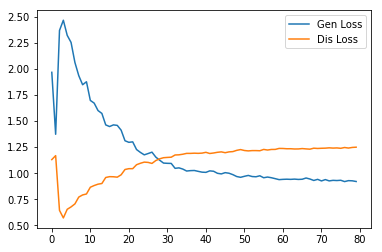

In [13]:
plt.plot(gen_loss, label="Gen Loss")
plt.plot(dis_loss, label="Dis Loss")
plt.legend()

#### Sample images from trained generator

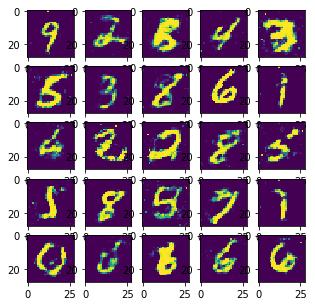

In [17]:
fig = plt.figure(figsize=(5,5))
generated_images = G(noise(25).cuda()).detach().cpu().numpy().reshape(25,28,28)*0.5 + 0.5
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(generated_images[i])
plt.show()

In [18]:
torch.save(G.state_dict(),"generator.pth")
torch.save(D.state_dict(),"discriminator.pth")

### Improving generation quality using discriminator

This is not a standard technique but a heuristic which I came up with. It might lead to reduction in variance of generated images.

Tested 920 images


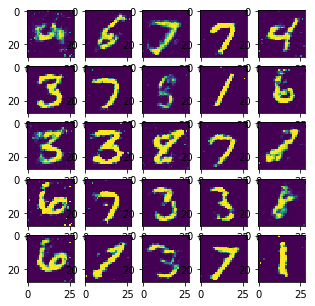

In [27]:
generated_images = []
counter = 0
with torch.no_grad():
    for i in range(25):
        pred = 0
        while pred<0.75:
            counter+=1
            img = G(noise(1).cuda())
            pred = D(img).cpu().item()
        generated_images.append(img.cpu().numpy().reshape(28,28)*0.5 + 0.5)

print("Tested {} images".format(counter))
fig = plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(generated_images[i])
plt.show()